In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('poster')
import beam.calc.electron as ecalc
from lens import profile
from scipy.optimize import minimize
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
from matplotlib.ticker import FormatStrFormatter

green = '#228833'
purple = '#AA3377'
cyan = '#33BBEE'
red = '#CC3311'
yellow = '#CCBB44'
orange = '#EE7733'
blue = '#0077BB'
magenta = '#EE3377'
# Not from the color palette
grey = '#444444'
denSize = 18
folder = 'LPAW-2019/'

z0: 45.374537453745376
ne0: 0.01199703251495801
bs: 10.055028400749334
ss: 47.84887020437034


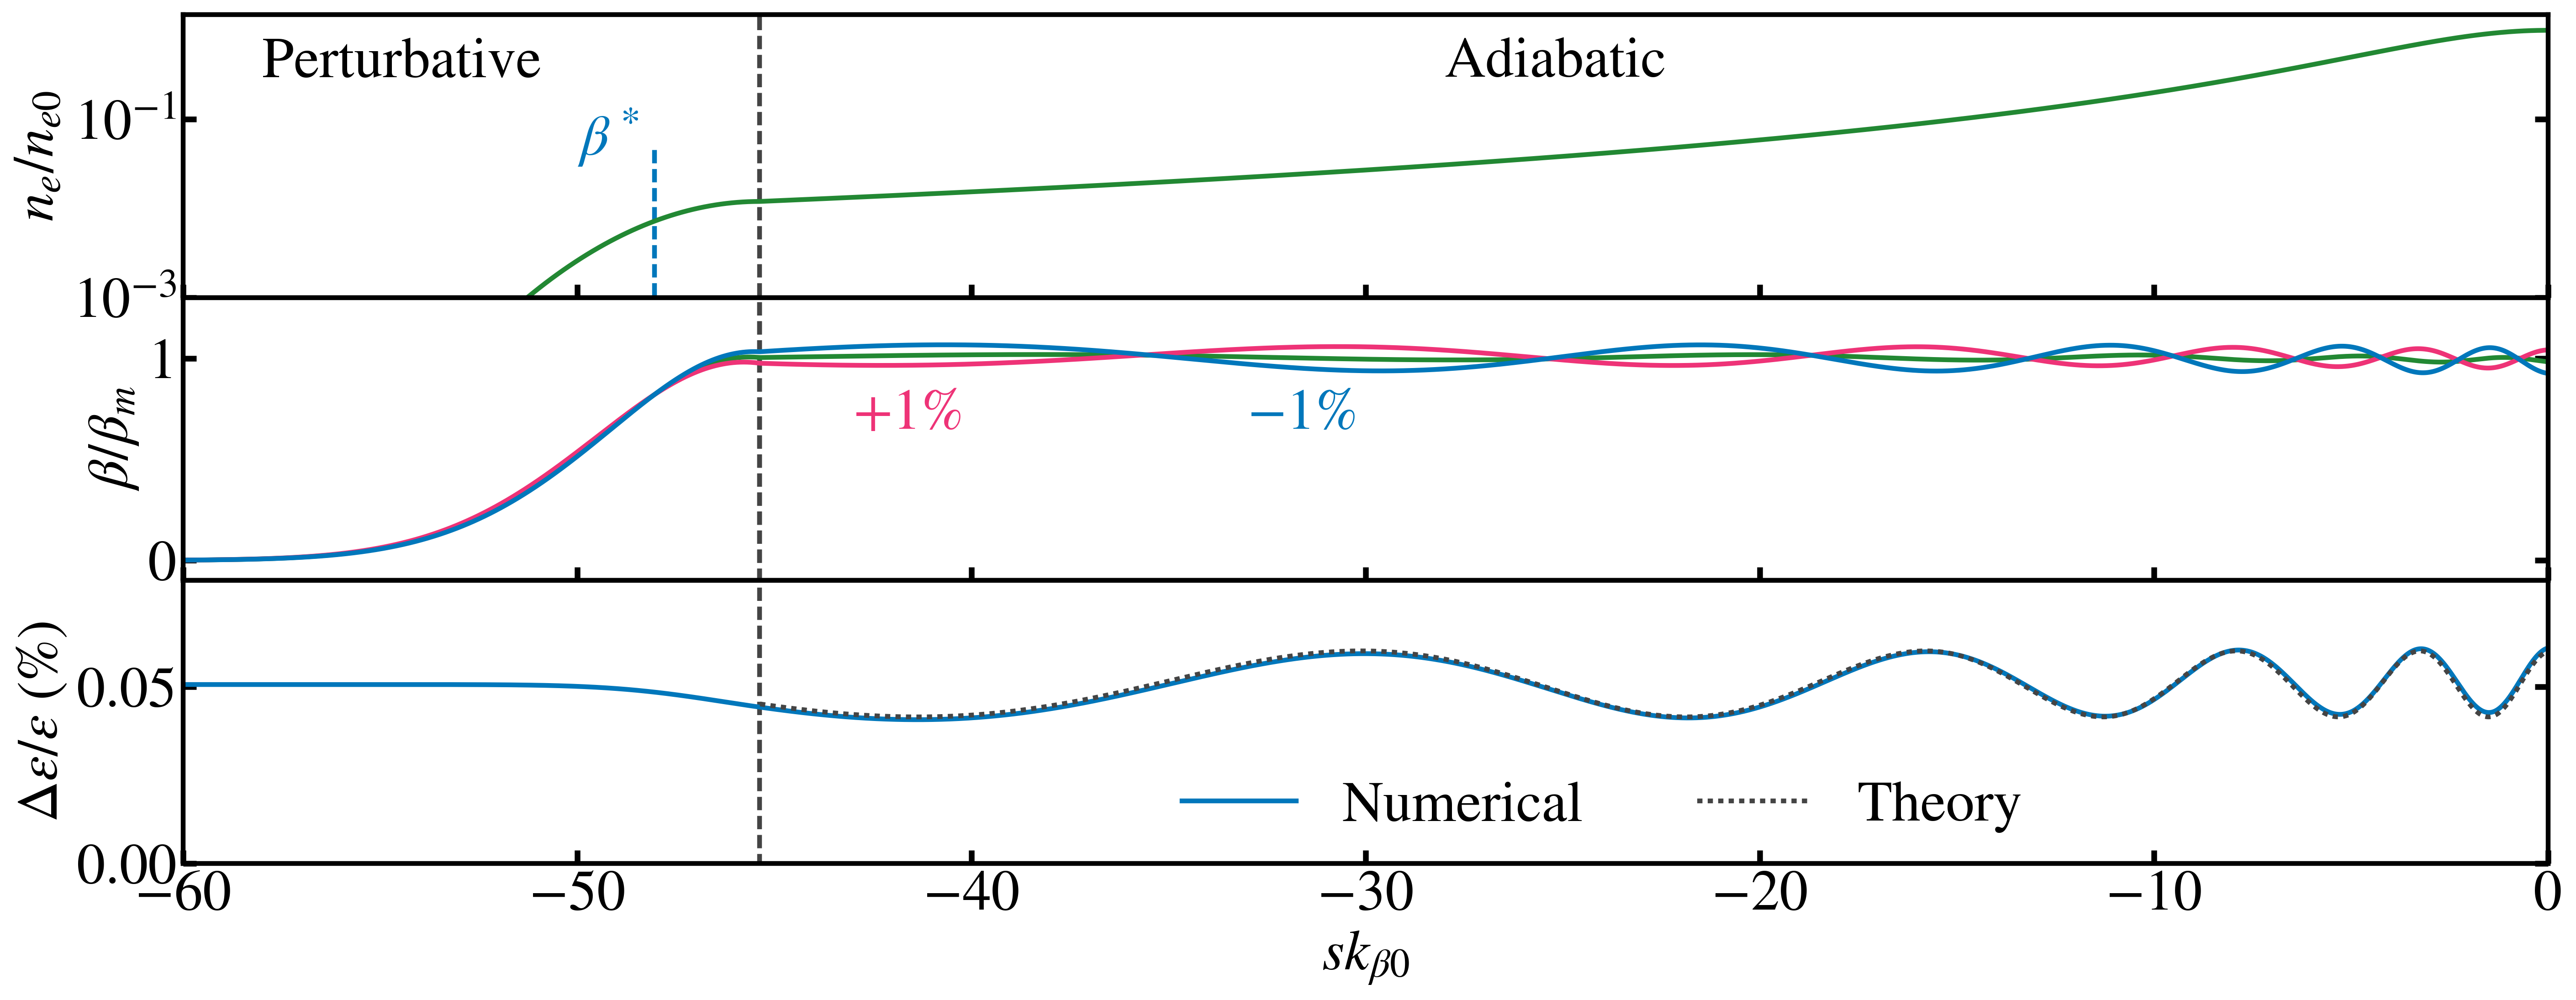

In [2]:
# Beam evolution and emittance growth in a pwfa
# Entrance ramp
N = 10000
beta0 = 1.0
alpha0 = 0.0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
z = np.linspace(0, 100, N)
frac = 1/(1+(a*z)**2)
sel = frac < 0.012
tran = z[sel][0]
print('z0:', tran)
print('ne0:', frac[sel][0])
ztran = z[sel]
# Numerical back propagatin says this is optimal for bs=10
#sigma = 2.541
sigma = 2.645
frac[sel] = frac[sel][0]*np.exp(-(ztran - z[sel][0])**2/(2*sigma**2))
ne = frac*ne0
# Forward propagate to make sure the output is what we expect it to be 
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Calculate free space propagation
bs = 1/gamma[-1]
ss = alpha[-1]*bs + 100
betaFree = (z-ss)**2/bs+bs
print('bs:', bs)
print('ss:', ss)

#------------------------------------------
# Create the up ramp and handle the chromatic input beam to see how everything works
Zmin = -100
bs0 = 10
ss = 48.041
delta = 0.01
ii = 5.5
z, dz = np.linspace(Zmin, 0, N, retstep=True)
beta0 = (Zmin+ss)**2/bs0+bs0
alpha0 = -(Zmin+ss)/bs0
frac = np.flip(frac, 0)
ne = frac*ne0
betam = 1/np.sqrt(frac)
# propagate the centroid energy and the extreme energy componenets
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
g1 = (1+ii**2*delta**2)/bs0
beta0d = 1/g1 + g1*((Zmin+ss)-ii*delta/g1)**2
alpha0d = ii*delta-g1*(Zmin+ss)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0d, alpha0d, gb0*(1+delta), dgdz0, ne0)
g1 = (1+ii**2*delta**2)/bs0
beta0d = 1/g1 + g1*((Zmin+ss)+ii*delta/g1)**2
alpha0d = -ii*delta-g1*(Zmin+ss)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0d, alpha0d, gb0*(1-delta), dgdz0, ne0)
sel = np.flip(sel, 0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    g1 = (1+ii**2*deltaA[i]**2)/bs0
    beta0d = 1/g1 + g1*((Zmin+ss)-ii*deltaA[i]/g1)**2
    alpha0d = ii*deltaA[i]-g1*(Zmin+ss)
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0d,
                                                                                  alpha0d, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(1/betam[np.logical_not(sel)])*dz

m = (1.64199 - 4.95517*ii)/9.06159
p = (-0.327629 + 0.780798*ii)/0.097085
am = a/2
a1 = (0.5 - 0.5*am**2-m-0.5*am**2*m)
a2 = am*(m-p)
a3 = 0.5*(1-am**2)-0.5*m*am**2
W2 = a1**2 + a2**2 + a3**2 + 2*a2*a3*np.sin(2*theta) - 2*a1*a3*np.cos(2*theta)

#plt.plot(deltaA,betaDelta[:,np.logical_not(sel)][:,0])
#plt.show()
#plt.plot(deltaA,alphaDelta[:,np.logical_not(sel)][:,0])
#plt.show()

#--------------------------------------------------
# Plotting
fig = plt.figure(figsize=(19.5, 8), dpi=300)
gs = gridspec.GridSpec(3, 1)

ax0 = plt.subplot(gs[0, 0])
ax0.plot(z, frac, color=green)
ax0.plot([-tran, -tran], [-.05, 1.5], '--', color=grey, zorder=0)
ax0.plot([-ss, -ss], [-.05, 5e-2], '--', color=blue, zorder=0)
ax0.tick_params(top=False,bottom=True,left=True,right=True,direction='in')
plt.ylabel(r'$n_e/n_{e0}$')
plt.yscale('log')
plt.ylim(0.001, 1.5)
#plt.text(-28, 0.85, 'Adiabatic')
#plt.arrow(-29, 0.9, -16.2, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.arrow(-17, 0.9, 17, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.text(-59, 0.85, 'Perturbative')
plt.text(-28, 0.3, 'Adiabatic')
plt.text(-58, 0.3, 'Perturbative')
plt.text(-50, 4e-2, r'$\beta^*$', color=blue)
plt.minorticks_off()

ax1 = plt.subplot(gs[1, 0], sharex=ax0)
ax1.plot(z, beta/betam, color=green)
ax1.plot(z, beta1/betam, color=magenta)
ax1.plot(z, betan1/betam, color=blue)
ax1.plot([-tran, -tran], [-.2, 1.5], '--', color=grey, zorder=0)
ax1.plot([-tran, -tran], [-.2, 1.5], '--', color=grey, zorder=0)
ax1.tick_params(top=False,bottom=True,left=True,right=True,direction='in')
plt.ylabel(r'$\beta/\beta_{m}$')
plt.text(-43, 0.65, r'$+1\%$', color=magenta)
plt.text(-33, 0.65, r'$-1\%$', color=blue)
plt.ylim(-0.1, 1.3)
#plt.text(-28, 0, 'Adiabatic')
#plt.arrow(-29, 0.07, -16.2, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.arrow(-17, 0.07, 17, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.text(-59, 1.1, 'Perturbative')

ax2 = plt.subplot(gs[2, 0], sharex=ax0)
ax2.plot(z, (eps-1)*1e2)
plt.plot(z[np.logical_not(sel)], 0.5*W2*delta**2*1e2/3, ':', c=grey)
ax2.plot([-tran, -tran], [-.2, 1.5], '--', color=grey, zorder=0)
ax2.tick_params(top=False,bottom=True,left=True,right=True,direction='in')
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
plt.ylim(0, 0.08)
plt.legend(['Numerical', 'Theory'], bbox_to_anchor=(.6, .2), loc='center', frameon=False, ncol=2)

plt.xlim(-60, 0)
plt.xlabel(r'$sk_{\beta0}$')


plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.savefig(folder+'Entrance_Ramp.eps')
plt.savefig(folder+'Entrance_Ramp.png')
plt.show()

In [3]:
# Store the variables we need for the full ramp picture
z_ent = z
beta_ent = beta
frac_ent = frac
ss_ent = ss
bs_ent = bs0

alpha_m= -0.5
28.94539453945395


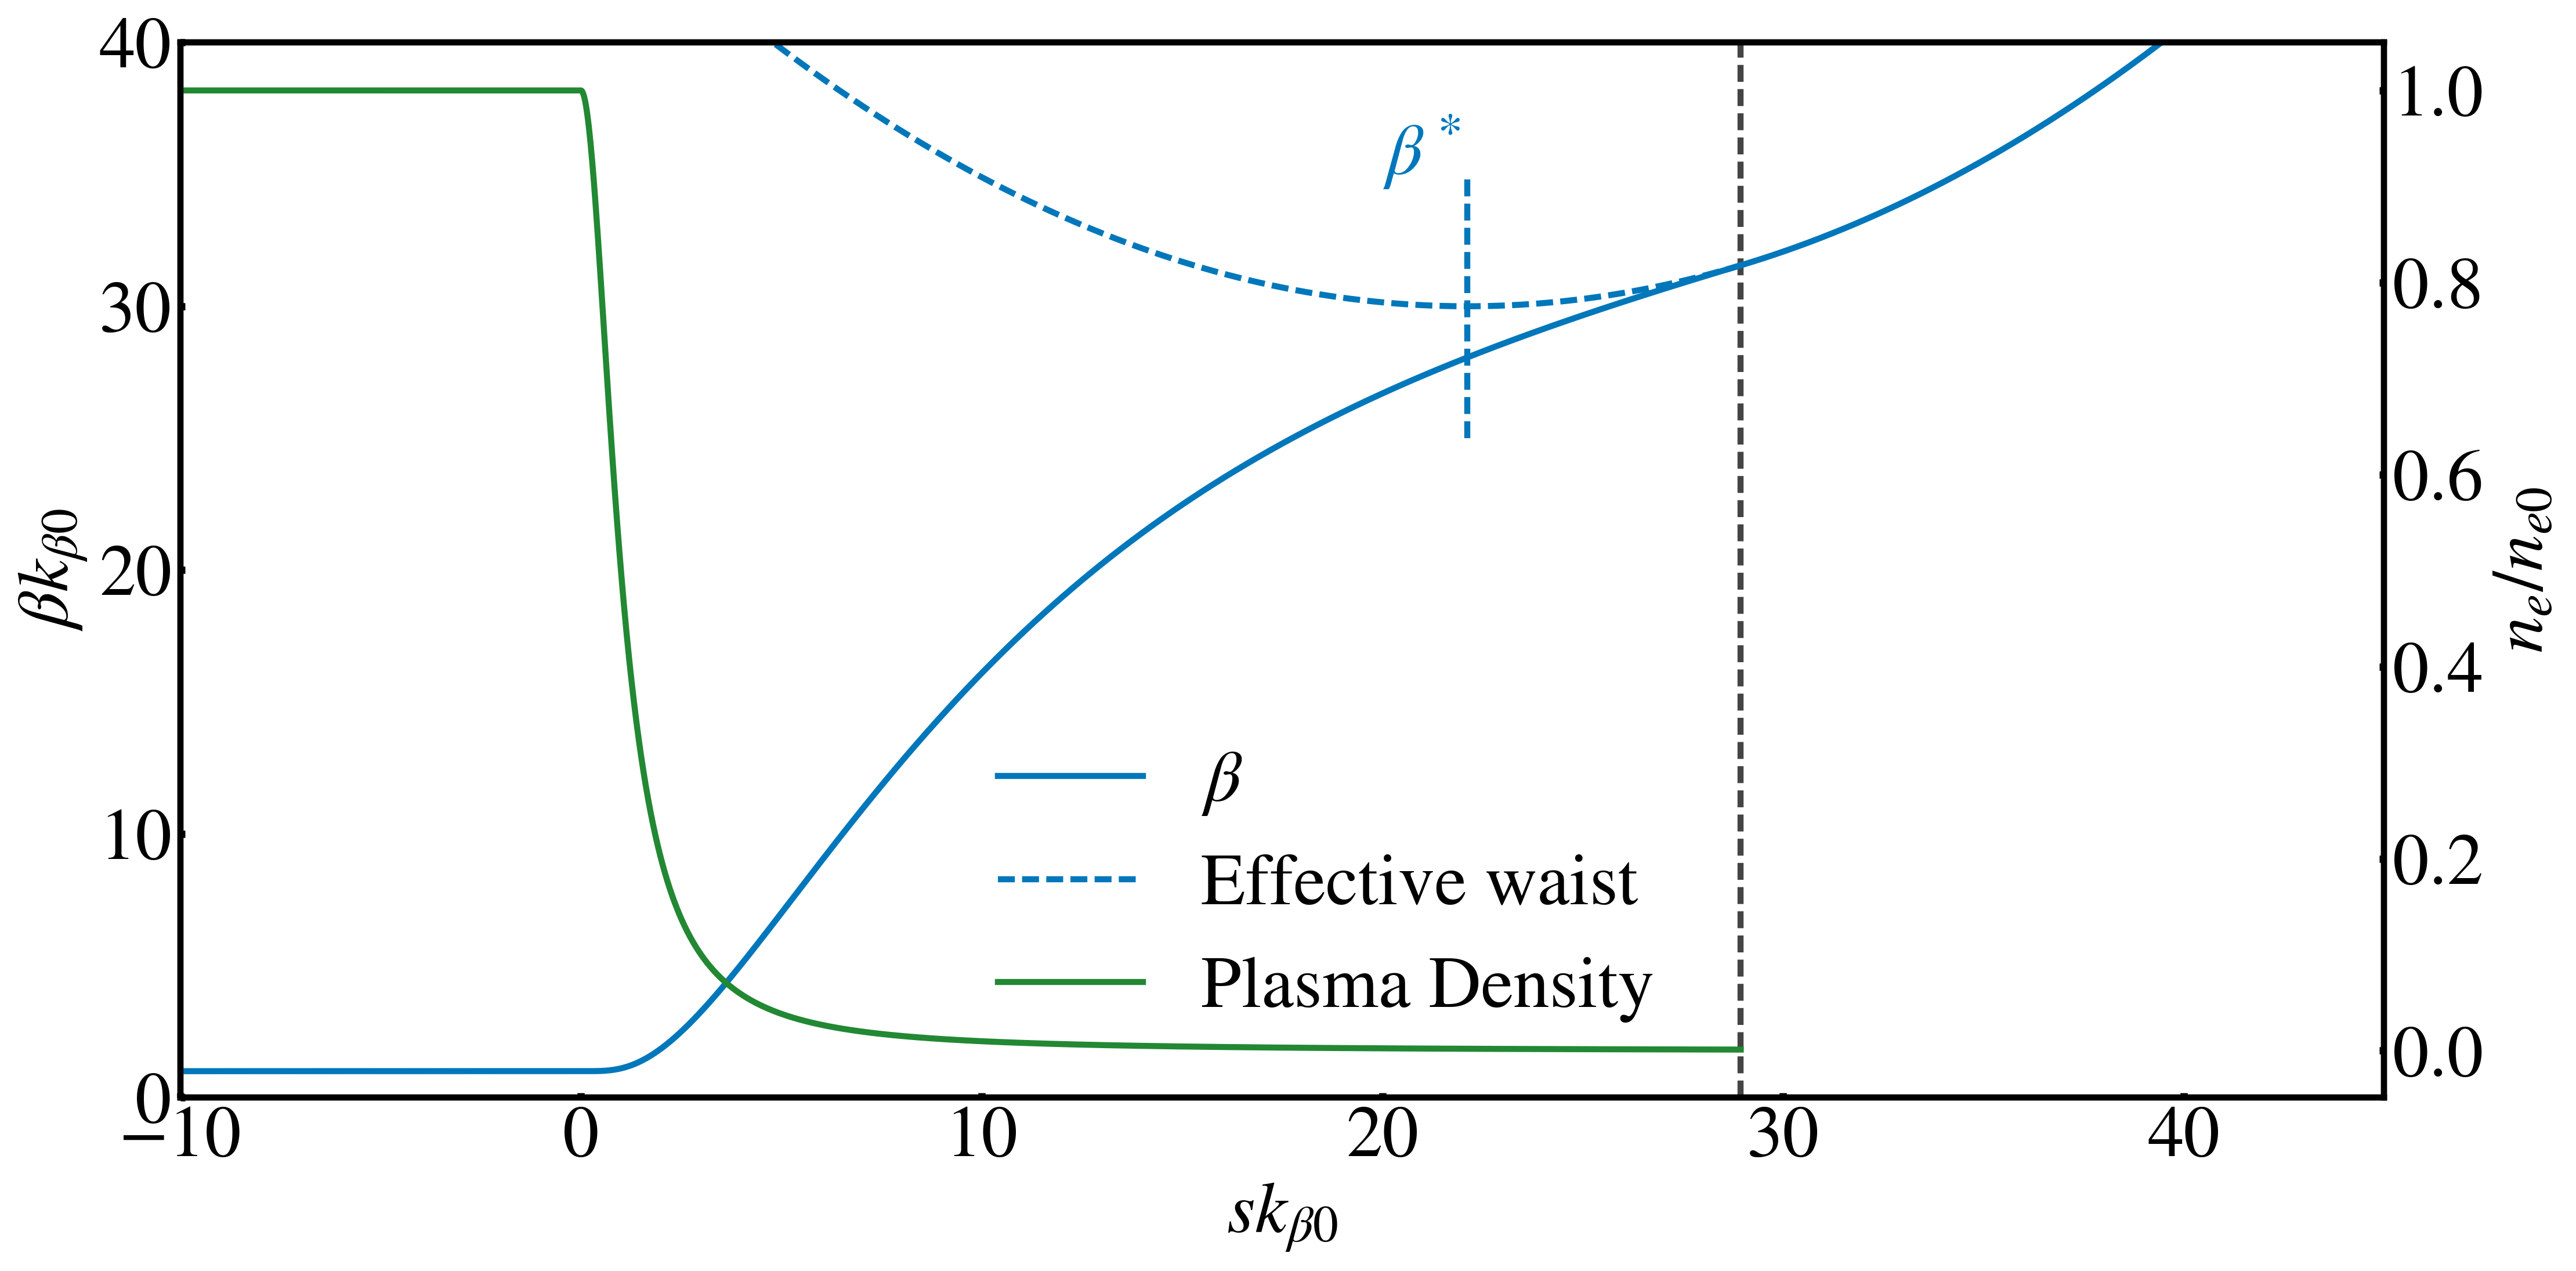

In [4]:
# Exit ramp
N = 10000
Zmax = 175
Zmin = -25
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 1.0
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(Zmin, Zmax, N, retstep=True)
frac = 1/(1+(a*z)**2)
frac[z<0] = 1.0
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Waist size along the ramp
betas = 1/np.array(gamma)
sel = betas < 30
sel2 = betas >= 30
tranz = z[sel]
tran = tranz[-1]
print(tran)
bs = betas[sel][-1]
ss = tran+np.array(alpha)[sel][-1]*bs
betaFree = (z-ss)**2/bs+bs

zp = np.linspace(Zmin, Zmax, N)
fig = plt.figure(figsize=(15.5, 8), dpi=300)
ax1 = plt.subplot(111)
ln1 = plt.plot(zp[sel], np.array(beta)[sel], label=r'$\beta$', zorder=10)
ln2 = plt.plot(zp[sel], betaFree[sel], '--', c=blue, label='Effective waist')
plt.plot(zp[sel2], betaFree[sel2], c=blue)
plt.plot([tran, tran], [0, 50], '--', c=grey, zorder=0, label=None)
#plt.plot([ss-tran, ss-tran], [0, 50], '--', c=grey, zorder=0, label=None)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.ylim(0, 40)
ax1.plot([ss, ss], [25, 35], '--', color=blue, zorder=0)
plt.text(20, 35, r'$\beta^*$', color=blue)

# Plasma density axis
ax2 = plt.twinx()
ln3 = ax2.plot(zp[sel], frac[sel], '-', color=green, label='Plasma Density')
plt.ylabel(r'$n_e/n_{e0}$')

plt.xlim(-10, 45)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
ax2.tick_params(top=False,bottom=True,left=False,right=True,direction='in',length=2)

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, frameon=False, bbox_to_anchor=(.52, .2), loc='center')

plt.tight_layout()
plt.savefig(folder+'Exit_Ramp.eps')
plt.savefig(folder+'Exit_Ramp.png')
plt.show()

In [5]:
# Store the variables we need for the full ramp picture
z_ext = zp[sel]
beta_ext = np.array(beta)[sel]
frac_ext = frac[sel]
ss_ext = ss
bs_ext = bs

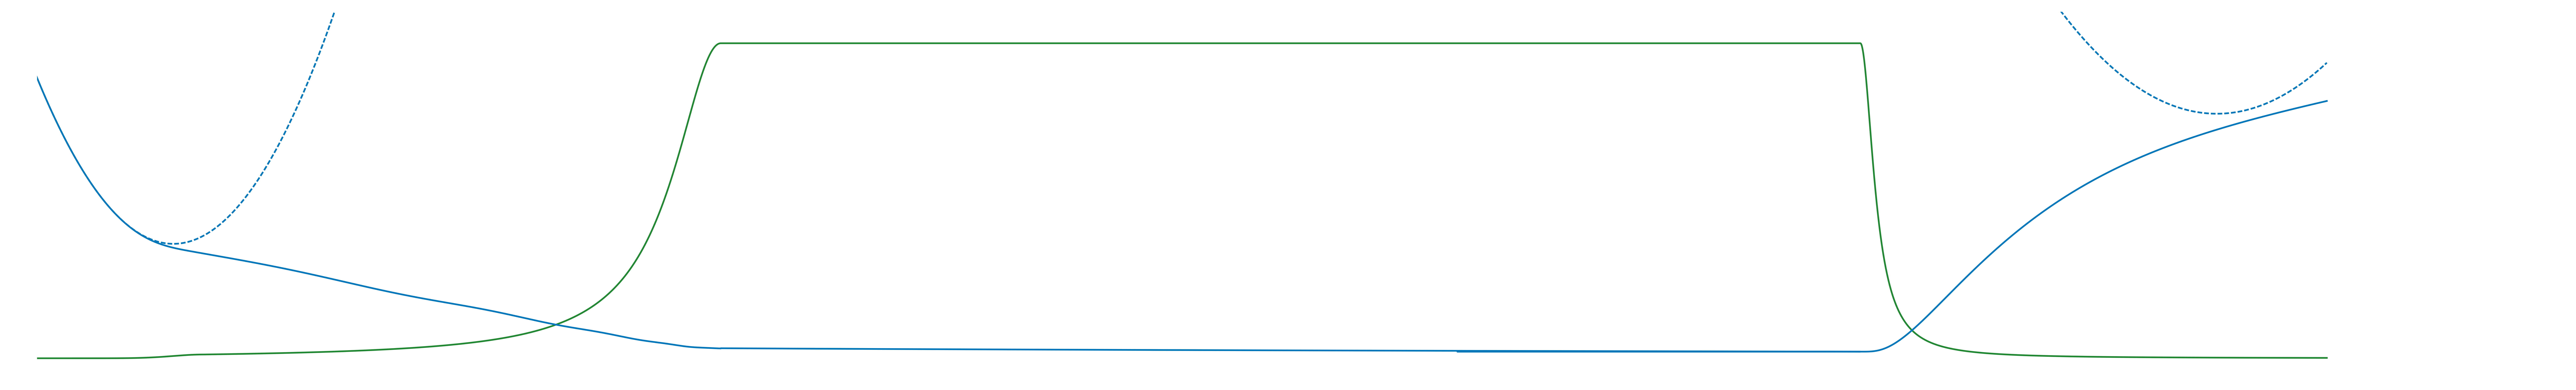

In [10]:
# Entrance ramp, accelerating plasma, exit ramp
# Use the ramp solutions from above for consistency
# Combine the two ramps into a single beta function
N_ent = len(z_ent)
N_ext = len(z_ext)
N_blk = 1000
L = 100 # Length of the bulk plasma
N = N_ent + N_ext + N_blk
z = np.zeros(N)
z[:N_ent] = z_ent
z[N_ent:N_ent+N_blk] = np.linspace(0, L, N_blk)
z[N_ent+N_blk:] = z_ext*np.sqrt(2)+L

frac = np.zeros(N)
frac[:N_ent] = frac_ent
frac[N_ent:N_ent+N_blk] = np.ones(N_blk)
frac[N_ent+N_blk:] = frac_ext

beta = np.zeros(N)
beta[:N_ent] = beta_ent
beta[N_ent:N_ent+N_blk] = 1/np.sqrt(np.linspace(1, 2, N_blk))
beta[N_ent+N_blk:] = beta_ext/np.sqrt(2)

# Vacuum beam propagation
ss_extc = ss_ext*np.sqrt(2)+L
bs_extc = bs_ext/np.sqrt(2)
bv_ent = (z+ss_ent)**2/bs_ent+bs_ent
bv_ext = (z-ss_extc)**2/bs_extc+bs_extc

# From this we need the beam envelope
r = np.sqrt(beta)
rf = np.sqrt(betaFree)

plt.figure(figsize=(48, 8), dpi=300, frameon=False)
plt.plot(z, frac, c=green, zorder=1)
#plt.fill_between(z, 0.0, np.flip(frac, 0), where=frac>=0.0, facecolor='#EEEEBB', zorder=0)
plt.ylim(-0.005, 1.1)
plt.axis('off')

plt.twinx()
plt.plot(z, beta, c=blue)
plt.plot(z, bv_ent, '--', c=blue)
plt.plot(z, bv_ext, '--', c=blue)
plt.ylim(0, 30)


plt.xlim(-60, 160)
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=1, left=-0.04, right=1.04) 
plt.savefig(folder+'Plasma_Source.eps')
plt.savefig(folder+'Plasma_Source.png')
plt.show()